## FUNCTION FOR DESCRIPTIVE STATISTICS: 

* This is the supporting single-firm / single-gvkey function for the main project found here:
    * https://github.com/Jspano95/Jspano_MScQFin_Thesis
    
* The actual function is found in the above repository in (.py) format; this is a stylised notebook with an example at the bottom.

In [1]:
## import packages ## 
import warnings
import sys
if not sys.warnoptions:
    warnings.filterwarnings("once")  

## graphing packages ## 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## date working / printing packages
import datetime
from datetime import date, timedelta, datetime
from tabulate import tabulate

## stats/math/econometrics packages 
import pandas as pd
import numpy as np    
import scipy as sp
from scipy import stats, integrate, optimize
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.stattools import adfuller, zivot_andrews 
import statsmodels.formula.api as smf  #VAR package contained within 
import statsmodels.tsa.api as smt
from arch.unitroot import DFGLS, ADF, ZivotAndrews, VarianceRatio

## econometrics warning utilities
from statsmodels.tools.sm_exceptions import ValueWarning
from arch.utility.exceptions import (
    InfeasibleTestException,
    InvalidLengthWarning,
    invalid_length_doc)
warnings.filterwarnings("once", category = ValueWarning)

C:\Users\JasonSpano\anaconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [11]:
## pickle file (from the main project)
sorted_alldata_df_final_adf_results = pd.read_pickle("./sorted_alldata_df_final_adf_results.pkl")

In [12]:
class color:
   #a simplified way to easily call different style elements for displaying outputs
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   GREEN = '\033[92m'
   HEADER = '\033[95m' 
   OKBLUE = '\033[94m'
   WARNING = '\033[93m'
   FAIL = '\033[91m'
   END = '\033[0m'

In [23]:
def single_series_model_outcomes_and_summary_statistics(gvkey_selection, dataframe, data_series, graphs='yes', 
                                    unit_root_tests='yes', vr_ratio='yes',
                                   za_test='yes', vecm_model='yes', **kwargs):
    """ 
    Returns all the key statistical tests and regressions models conducted on the entire data sample in the main project.
    This function will run identical test specifications but pertaining only to a single specified GVKEY. 
    
    Parameters
    ----------
    gvkey_selection: int
        The selected GVKEY (unique group identifier)
    dataframe: 
        The DataFrame which contains the relevant GVKEY's CDS and PECDS data series
    data_series: array_like
        The chosen primary data series to display summary statistics for
    graphs: bool, optional
        Will display data series with known breakpoints in graphical form
    unit_root_tests: bool, optional
        Will return the ADF and DFGLS unit root test results on the selected [data_series]
    vr_ratio: bool, optional
        Will return the Variance Ratio test on the selected [data_series]
    vr_ratio_increment: int, optional
        The size of the Variance Ratio increments to conduct the joint variance tests on. Default is 2.5%
    za_test: bool, optional
        Will return the results of the Zivot Andrews Breakpoint test
    vecm_model: bool, optional
        Will return the results of the Vector Error Correction Model and Granger Causality Test Results within the VECM framework
        Associated price discovery leadership methods (GG and HAS measures) are also included.
        
    
    """
    data_series = str(data_series)
    
    ###  group/gvkey general identifiers 
    gvkey_group_df = dataframe.loc[dataframe.gvkey==gvkey_selection]
    
    print(color.BOLD + '\n', "--"*38, '\n', "--"*38, '\n', color.OKBLUE + "//"*10, 
          "<< SUMMARY MODEL OUTCOMES VIEWER >> ",  "//"*9, color.END, '\n', "--"*38, '\n', "--"*38, '\n')
   
    ## print general overview items for the selected GVKEY
    print(tabulate([['COMPANY NAME', gvkey_group_df.company_name.iloc[0]],
                   ['COMPANY SECTOR', gvkey_group_df.sector.iloc[0]],
                   ['BOND ID', gvkey_group_df.bond_sym_id.iloc[0]]],
                   headers=[color.BOLD + 'SELECTED GVKEY: ', str(gvkey_selection) + color.END],
                   tablefmt='pretty', numalign='center'))

    ### extract just the relevant date elements from the trade_date timestamp 
    time_min_string = str(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection]['trade_date'].min())
    time_max_string = str(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection]['trade_date'].max())

    time_min_str_strip = datetime.strptime(time_min_string, '%Y-%m-%d %H:%M:%S')
    time_max_str_strip = datetime.strptime(time_max_string, '%Y-%m-%d %H:%M:%S')

    date_ymd_min = time_min_str_strip.strftime('%Y-%m-%d')
    date_ymd_max = time_max_str_strip.strftime('%Y-%m-%d')

    print(tabulate([['TOTAL OBS', gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series].count()],
                   ['FIRST OBS', date_ymd_min],
                   ['LAST OBS', date_ymd_max],
                   ['TIME HORIZON (DAYS)', (gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection]['trade_date'].max() - 
                                     gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection]['trade_date'].min()).days]],
                   headers=[color.BOLD + 'SELECTED SERIES: ', data_series.upper() + color.END],
                   tablefmt='pretty', numalign='center'))
    
    print(color.BOLD, "// SUMMARY SERIES STATISTICS // ", color.END)
    
    
    #### print general descriptive statistics pertaining to the selected series on the GVKEY
    quartiles = np.quantile(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection]['market_cds_spread'], [0.25, 0.75])
    
    print(tabulate([['MEAN', np.round(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series].mean(), 2)],
                    ['MIN VALUE', gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series].min()],
                    ['MAX VALUE', gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series].max()],
                    ['VALUE RANGE', np.round(np.ptp(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series]),4)],
                    ['25% QUANTILE', np.round(quartiles[0],2)],
                    ['75% QUANTILE', np.round(quartiles[1],2)],
                    ['INT-Q RANGE', np.round((quartiles[1] - quartiles[0]),2)],
                    ['STD DEVIATION', np.round(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series].std(), 2)],
                    ['NORMALISED STDDEV', np.round(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series].std() / 
                        gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series].mean(), 2)],
                    ['SKEW', np.round(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series].skew(),2)],
                    ['KURTOSIS', np.round(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series].kurtosis(),2)]],
                    headers=[color.BOLD + 'DATA ITEM', 'VALUE' + color.END],
                    tablefmt='pretty', numalign='center'))
    
    ## overlay skew/kurtosis with KDE of market CDS spread
    if graphs=='yes':
        try:
            fig_cds_skew = plt.figure(figsize=(6, 4))

            cds_skew_overlay_graph = fig_cds_skew.add_subplot(sns.distplot(gvkey_group_df[data_series],  
                                                                           kde=True, fit=stats.norm))
        
            plt.title("{} SKEW AND KURTOSIS OVERLAID BY ~N(0,1) KDE".format(
                data_series.upper()), loc='center', fontsize=10)
            
            plt.show()
            
        except Exception: 
            print('\n', color.BOLD + color.RED, "Error Fitting KDE graph to selected series", color.END, '\n')

    
    ##### UNIT ROOT TESTS #####
    ##### ADF TEST 
    
    if unit_root_tests=='yes':
        try:
            print('\n', '--'*38, '\n', color.BOLD + "UNIT ROOT TESTS" + color.END)
            
            ADF_model = ADF(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series], lags=10)
            
            dfgls_model = DFGLS(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series], 
                               max_lags=10, method='BIC')
        
            if ADF_model.stat <= ADF_model.critical_values['5%']:
                adf_model_outcome = ADF_model.alternative_hypothesis
            else:
                adf_model_outcome = ADF_model.null_hypothesis   
        
            if dfgls_model.stat <= dfgls_model.critical_values['5%']:
                dfgls_model_outcome = dfgls_model.alternative_hypothesis
            else:
                dfgls_model_outcome = dfgls_model.null_hypothesis
        
            print(tabulate([['ADF TEST', np.round(ADF_model.stat, 4), 
                             np.round(ADF_model.critical_values['5%'],4), adf_model_outcome],
               ['DFGLS TEST', np.round(dfgls_model.stat, 4), 
               np.round(dfgls_model.critical_values['5%'],4), dfgls_model_outcome]],
               headers=[color.BOLD + 'TEST TYPE', 'TEST STAT', 'TEST 5% CV', 'TEST OUTCOME' + color.END],
                           tablefmt='pretty', numalign='center'))
        
        except IndexError as unitroot_ie:
            print("DFGLS/ADF MODEL ERROR //", unitroot_ie.args)  
            
        except AssertionError as unitroot_ae:
            print("ADF MODEL ERROR //", unitroot_ae.args)
        
    else:
        print("UNIT ROOT TESTING NOT SELECTED")
        
    
    ## VARIANCE RATIO
    
    if vr_ratio=='yes':
        try:
            print('\n', color.BOLD + "--"*38 + '\n', "VARIANCE RATIO" + color.END)

            ## check if optional parameter is passed in for VR ratio increment
            vr_ratio_increment = kwargs.get('vr_ratio_increment')
            
            ## if no optional argument is passed in for the Variance Ratio Test: Default is 2.5% (40 equal increments)
            if vr_ratio_increment is None:
                lag_length_vr_test = 0.025
            else: 
                lag_length_vr_test = vr_ratio_increment

            ## take the floor (lowest closest interger of the increment (lag-size) length)) & run model instance
            variance_ratio_increment_size = np.floor(
            lag_length_vr_test * len(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series]))    

            variance_ratio_model = VarianceRatio(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series],
                                                trend='c', robust=True, lags=int(variance_ratio_increment_size))

            ## tabulate results of the variance ratio from the above specified test parameters:
            print(tabulate([['VARIANCE RATIO', np.round(variance_ratio_model.vr, 2)],
                           ['VR TEST STAT', np.round(variance_ratio_model.stat, 2)],
                           ['VR P-VALUE', np.round(variance_ratio_model.pvalue, 4)],
                           ['VR LAGS USED', np.round(variance_ratio_model.lags, 2)]],
                           tablefmt='pretty', numalign='center'))

            if variance_ratio_model.stat >= variance_ratio_model.critical_values['95%']:
                print(color.BOLD + "VR TEST-STATISTIC CONCLUSION:", color.END + "{}".format(
                    variance_ratio_model.alternative_hypothesis), '\n', "--"*38)
            else:
                print(color.BOLD + "VR TEST-STATISTIC CONCLUSION: ", color.END + "{}".format(
                    variance_ratio_model.null_hypothesis), '\n', "--"*38)
                
        except RuntimeWarning as vr_rtw:
            print(vr_rtw.args)

       
    #### ZA BREAKPOINT TEST ####
    if za_test=='yes':
        print('\n', color.BOLD + "--"*38 + '\n', "ZIVOT ANDREWS BREAKPOINT TEST" + color.END)
        
        try:
            statsmodels_za = zivot_andrews(gvkey_group_df.loc[gvkey_group_df.gvkey==gvkey_selection][data_series],
                                            trim=0.2, maxlag=10, regression='c', autolag='t-stat')

            ## assign an outcome to the ZA test based off the test statistic
            if statsmodels_za[1] <= statsmodels_za[2]['5%']:
                za_outcome_str = 'process is trend/break stationary'
            else:
                za_outcome_str = 'process is UR with structural break'
            
            print(tabulate([['ZA TEST STAT', np.round(statsmodels_za[1],2)], 
            ['5% ZA CRIT VALUE ', np.round(statsmodels_za[2]['5%'],4)],
            ['ZA PVALUE ', np.round(statsmodels_za[3], 4)],
            ['ZA OUTCOME ', za_outcome_str]],
            headers=[color.BOLD + 'ZA TEST ITEM', 'VALUE' + color.END], 
            tablefmt='pretty', numalign='center'))             
            
            #### determine the real data associated with the breakpoint ####
            #### [this occurs where the ADF unit root t-stat is minimised (most negative)]
            ## define the date series from the original DF:
            date_series = gvkey_group_df['trade_date']

            ## find the corressponding date to the ZA breakpoint
            index_location_za_bpoint = statsmodels_za[4]
            
            date_location_za = str(date_series.iloc[index_location_za_bpoint])
            
            date_location_za_strp = datetime.strptime(date_location_za, '%Y-%m-%d %H:%M:%S')
            
            date_location_za_clean = date_location_za_strp.strftime('%Y-%m-%d')

            print(color.BOLD + "CALCULATED BREAKPOINT DATE: " + color.END + "{}".format(date_location_za_clean), '\n',  "--"*38, '\n')    

        except (InfeasibleTestException, UnboundLocalError) as za_model_errors:
             print("Unable to calculate ZivotAndrews Breakpoint Test - Reason: {}".format(za_model_errors.args))
    
    else:
        print('\n', "ZIVOT ANDREWS BREAKPOINT NOT CALCULATED. THIS MAY AFFECT PROPER CONSTRUCTION OF LINE-GRAPHS", '\n')                    

    
    ##### VECM ITEMS & PRICE DISCOVERY MEASURES #####
    if vecm_model=='yes':
        try:
            print('\n', "--"*38, '\n', color.BOLD + "VECM MODEL & PRICE DISCOVERY MEASURES", color.END)

            ## VECM MODEL CONSTRUCTION -- only valid on the two series: CDS + PECDS
            vecm_data_df = pd.DataFrame(data=(gvkey_group_df['market_cds_spread'], gvkey_group_df['pecds'])).T

            optimal_bic_lags = vecm.select_order(vecm_data_df, maxlags=10)

            vecm_cointegration_rank = vecm.select_coint_rank(vecm_data_df, det_order=1, k_ar_diff = optimal_bic_lags.bic,
                                                           method='trace',signif=0.05)

            ## limit max cointegrating relationships to one as it's a dual-variable system.
            if vecm_cointegration_rank.rank >=1:
                cointegrating_rels = int(1)
            else:
                cointegrating_rels = int(0)
                
            print(color.BOLD + " COINTEGRATION RANK: " + color.END, "{}".format(cointegrating_rels),
                 '\n','--'*38)

            vecm_model_fitted = vecm.VECM(vecm_data_df, k_ar_diff = optimal_bic_lags.bic, coint_rank=cointegrating_rels,
                          deterministic='co').fit()

            cholesky_decomp = np.linalg.cholesky(vecm_model_fitted.sigma_u)
            sig_1 = cholesky_decomp[0, 0]
            sig_12 = cholesky_decomp[1, 0]
            sig_2 = cholesky_decomp[1, 1]

            x_1 = vecm_model_fitted.alpha[0,0]
            x_2 = vecm_model_fitted.alpha[1,0]

            gg_val = np.round(vecm_model_fitted.alpha[1,0] / vecm_model_fitted.alpha[1,0] - vecm_model_fitted.pvalues_alpha[0,0], 2)

            HAS_1 = np.round(( x_2**2 * (sig_1**2 - sig_12**2 / sig_2**2) )  / ( x_2**2 * sig_1**2 - 2*x_1*x_2*sig_12 + x_1**2 * sig_2**2 ),4)
            HAS_2 = np.round(( (x_2 * sig_1 - x_1 * sig_12 / sig_1)**2 ) / ( x_2**2 * sig_1**2 - 2*x_1*x_2*sig_12 + x_1**2 * sig_2**2 ),4)
            HAS_mid = np.round((HAS_2 + HAS_1) / 2,4)

            print(tabulate([['GG VALUE', gg_val],
                   ['HAS LOWER', HAS_1],
                   ['HAS MID', HAS_mid],
                   ['HAS UPPER', HAS_2]],
                   headers=[color.BOLD + 'PRICE DISCOVERY', 'VALUE' + color.END], tablefmt='pretty', numalign='center'),
                 '\n', color.GREEN, "[ VALUES > 0.5 FAVOUR CDS |&| VALUES < 0.5 FAVOUR BONDS ]", color.END)

            print(tabulate([['EQ(1) | Alpha(1) ', np.round(vecm_model_fitted.alpha[0,0], 5), np.round(vecm_model_fitted.pvalues_alpha[0,0], 4)],
                   ['EQ(2) | Alpha(1)', np.round(vecm_model_fitted.alpha[1,0], 5), np.round(vecm_model_fitted.pvalues_alpha[1,0], 4)]],
                   headers=[color.BOLD + 'VECM MODEL', 'TEST STAT','P-VALUE' + color.END],
                   tablefmt='pretty', numalign='center'))

            print('\n', color.BOLD + "// GRANGER CAUSALITY TESTS // " + color.END)
            print(tabulate([['PECDS CAUSES CDS',np.round(vecm_model_fitted.test_granger_causality(caused=0).test_statistic, 4),
                           vecm_model_fitted.test_granger_causality(caused=0).conclusion_str[11:]],
                           ['CDS CAUSES PECDS', np.round(vecm_model_fitted.test_granger_causality(caused=1).test_statistic, 4),
                           vecm_model_fitted.test_granger_causality(caused=1).conclusion_str[11: ]]],
                           headers=[color.BOLD + 'GRANGER TEST', 'TEST STAT',
                          'TEST CONCLUSION' + color.END], tablefmt='pretty', numalign='center'))

        except ValueError as vecm_ve:
            print(vecm_ve.args)
            
        except InfeasibleTestException as vecm_ite:
            print(vecm_ite.args)
            
        except IndexError as vecm_ie:
            print('\n', "Highly probable no significant cointegrating relationship was found", '\n', vecm_ie.args)
            
            
   
    
    
    ## <OPTIONAL> show graphs by year for the CDS series
    print("--"*38, '\n')
    if graphs=='yes':
        try:
            print(color.BOLD + "SELECTED VISUAL REPRESENTATIONS OF GVKEY [{}] |&| FOCUSED SERIES: [{}]".format(
                gvkey_selection, data_series.upper()) + color.END)

            ## define a new DF with trade_date as the index for plotting the ZA breakdate
            ## note: this graph calls the ZA breakdate from the DF (not from the above calculation)
            ## this is to allow the graphs to display the supposed ZA breakdate while maintaining printing results as optional
            gvkey_group_df_timeind = gvkey_group_df.set_index(['trade_date'])
            za_bp_date_raw = str(gvkey_group_df.ZA_BREAKDATE.iloc[0])
            za_bp_date_strp = datetime.strptime(za_bp_date_raw, '%Y-%m-%d %H:%M:%S')

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            fig.suptitle('GVKEY [{}] CDS & PECDS LINE GRAPHS WITH ZA-BREAKPOINT'.format(gvkey_selection))

            ## PLOT CDS 
            sns.lineplot(x=gvkey_group_df_timeind.index, 
                         y='market_cds_spread', 
                         data=gvkey_group_df_timeind,  
                         palette='winter',
                         markers=True,
                         dashes=False,
                         legend='full',
                         ax=ax1)

            ## AFFIX THE ZIVOT-ANDREWS BREAKDPOINT 
            ax1.set_ylabel("DAILY CDS VALUES", fontsize=12)
            ax1.axvline(za_bp_date_strp, 0, color='r', linestyle='--', label='ZA BREAKPOINT')
            ax1_labels=['ZA BREAKPOINT']
            handles_1, _ = ax1.get_legend_handles_labels()
            ax1.legend(handles=handles_1, labels=ax1_labels)

            ## PLOT PECDS
            sns.lineplot(x=gvkey_group_df_timeind.index, 
                         y=gvkey_group_df_timeind['pecds'], 
                         data=gvkey_group_df_timeind,  
                         palette='RdGy_r',
                         legend='full',
                         ax=ax2)

            ## AFFIX THE ZIVOT-ANDREWS BREAKDPOINT 
            ax2.set_ylabel("DAILY PECDS VALUES",  fontsize=12)
            ax2.axvline(za_bp_date_strp, 0, color='r', linestyle='--', label='ZA BREAKPOINT')
            ax2_labels=['ZA BREAKPOINT']
            handles_2, _ = ax2.get_legend_handles_labels()
            ax2.legend(handles=handles_2, labels=ax2_labels)

            plt.show()
            
        except ValueError as ve_graphs:
            print("Zivot Andrews BP Error -- Full Graph Unavailable", '\n',"--"*38, '\n', "// SHOWING SIMPLIFIED VERSION // ")
            
            gvkey_group_df_timeind = gvkey_group_df.set_index(['trade_date'])
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            fig.suptitle('GVKEY [{}] CDS & PECDS SIMPLE GRAPHS'.format(gvkey_selection))            
            
            ## plot just a simple line graph of both the: CDS and PECDS series 
            sns.lineplot(x=gvkey_group_df_timeind.index, 
                         y='market_cds_spread', 
                         data=gvkey_group_df_timeind,  
                         palette='winter',
                         markers=True,
                         dashes=False,
                         legend='full',
                         ax=ax1)
            
            ax1.set_ylabel("DAILY CDS VALUES", fontsize=12)

            sns.lineplot(x=gvkey_group_df_timeind.index, 
                         y=gvkey_group_df_timeind['pecds'], 
                         data=gvkey_group_df_timeind,  
                         palette='RdGy_r',
                         legend='full',
                         ax=ax2)

            ax2.set_ylabel("DAILY PECDS VALUES",  fontsize=12)            
            
    
    else:
        print('\n', "GRAPHS SET TO NO-SHOW", '\n', "--"*38)
        pass

    


 ---------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------- 
 //////////////////// << SUMMARY MODEL OUTCOMES VIEWER >>  //////////////////  
 ---------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------- 

+------------------+-----------------------------+
| SELECTED GVKEY:  |            1045             |
+------------------+-----------------------------+
|   COMPANY NAME   | AMERICAN AIRLINES GROUP INC |
|  COMPANY SECTOR  |        Transporation        |
|     BOND ID      |           AMR.UY            |
+------------------+-----------------------------+
+---------------------+-------------------+
|  SELECTED SERIES:   | MARKET_CDS_SPREAD |
+---------------------+-------------------+
|      TOTAL OBS      |        546        |
|      FIRST OBS      |    2009-09-24     |
|      LAST OBS       |  

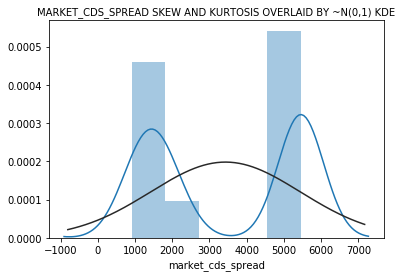


 ---------------------------------------------------------------------------- 
 UNIT ROOT TESTS
+------------+-----------+------------+-----------------------------------+
| TEST TYPE  | TEST STAT | TEST 5% CV |           TEST OUTCOME            |
+------------+-----------+------------+-----------------------------------+
|  ADF TEST  |  -1.0259  |   -2.867   | The process contains a unit root. |
| DFGLS TEST |  -0.2413  |  -1.9826   | The process contains a unit root. |
+------------+-----------+------------+-----------------------------------+

 ----------------------------------------------------------------------------
 VARIANCE RATIO
+----------------+--------+
| VARIANCE RATIO |  1.02  |
|  VR TEST STAT  |  0.96  |
|   VR P-VALUE   | 0.3392 |
|  VR LAGS USED  |   13   |
+----------------+--------+
VR TEST-STATISTIC CONCLUSION:  The process is a random walk. 
 ----------------------------------------------------------------------------

 ------------------------------------------

C:\Users\JasonSpano\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:1111: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(concatenate(arr_rows, axis=0))



---------------------------------------------------------------------------- 

SELECTED VISUAL REPRESENTATIONS OF GVKEY [1045] |&| FOCUSED SERIES: [MARKET_CDS_SPREAD]


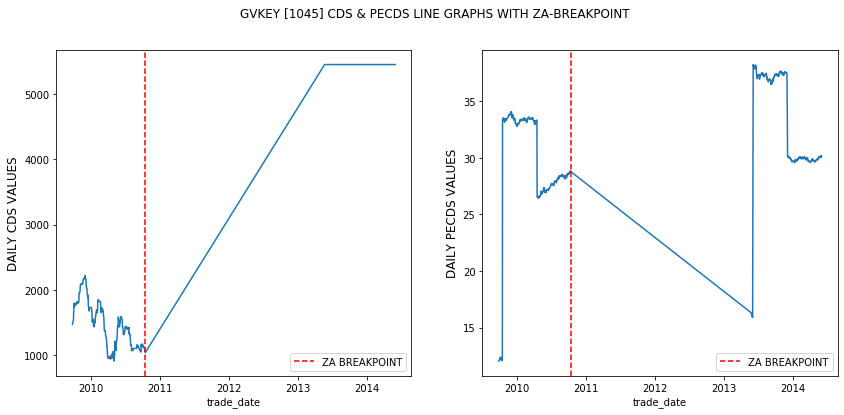

In [9]:
#E.G. 
single_series_model_outcomes_and_summary_statistics(gvkey_selection=1045, dataframe=sorted_alldata_df_final_adf_results,
                                data_series='market_cds_spread', graphs='yes', vr_ratio_increment=0.025,
                                unit_root_tests='yes', vr_ratio='yes', 
                               za_test='yes', vecm_model='yes')

